In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax
from PIL import Image  # Import the Image module from PIL

# Load the pre-trained model and compile it
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Pneumonia Detection.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Path to the image
image_path = '/content/IM-0241-0001.jpeg'

# Open and preprocess the image
image = Image.open(image_path)
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
predicted_label = class_labels[tf.argmax(score)]

print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 2s 2s/step
Predicted class: Normal


1/1 [==============================] - 2s 2s/step
Pneumonia Detection Predicted class: Normal


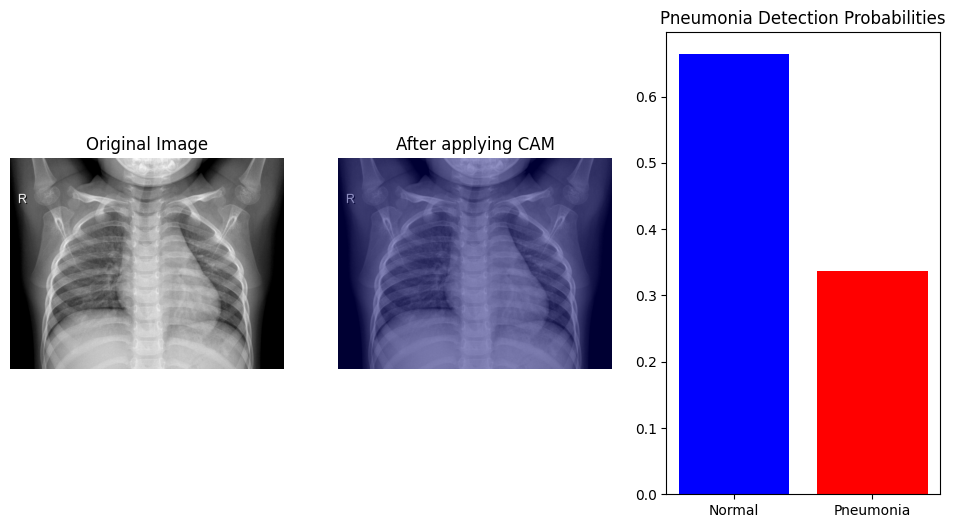

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing import image as tf_image
from PIL import Image

# Load the pre-trained model for pneumonia detection and compile it
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Pneumonia Detection.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Load the pre-trained ResNet50 model for CAM
resnet_model = ResNet50(weights='imagenet')
img_path = '/content/IM-0241-0001.jpeg'

# Open and preprocess the image for pneumonia detection
image_pneumonia = Image.open(img_path)
img_pneumonia = image_pneumonia.resize((224, 224))
img_array_pneumonia = tf.keras.preprocessing.image.img_to_array(img_pneumonia)
img_array_pneumonia = tf.expand_dims(img_array_pneumonia, 0)

# Make predictions for pneumonia detection
predictions_pneumonia = loaded_model.predict(img_array_pneumonia)
class_labels_pneumonia = ['Normal', 'Pneumonia']
score_pneumonia = tf.nn.softmax(predictions_pneumonia[0])
predicted_label_pneumonia = class_labels_pneumonia[tf.argmax(score_pneumonia)]

print(f"Pneumonia Detection Predicted class: {predicted_label_pneumonia}")

# Preprocess the image for CAM
img = tf_image.load_img(img_path, target_size=(224, 224))
x = tf_image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Obtain CAM visualization
class_index = np.argmax(predictions_pneumonia[0])
last_conv_layer = resnet_model.get_layer('conv5_block3_out')
cam_model = tf.keras.Model(inputs=resnet_model.input, outputs=(last_conv_layer.output, resnet_model.output))

with tf.GradientTape() as tape:
    last_conv_output, preds = cam_model(x)
    class_output = preds[:, class_index]

grads = tape.gradient(class_output, last_conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_output = last_conv_output[0]
heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Generate CAM overlay on the original image
original_img = cv2.imread(img_path)
height, width, _ = original_img.shape
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (width, height))
heatmap = (heatmap * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
cv2.imwrite('cam.jpg', superimposed_img)

# Display results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('After applying CAM')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(class_labels_pneumonia, score_pneumonia.numpy(), color=['blue', 'red'])
plt.title('Pneumonia Detection Probabilities')

plt.show()

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing import image as tf_image
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages

# Load the pre-trained model for pneumonia detection and compile it
loaded_model = tf.keras.models.load_model('/content/Pneumonia Detection.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Load the pre-trained ResNet50 model for CAM
resnet_model = ResNet50(weights='imagenet')
img_path = '/content/IM-0241-0001.jpeg'

# Open and preprocess the image for pneumonia detection
image_pneumonia = Image.open(img_path)
img_pneumonia = image_pneumonia.resize((224, 224))
img_array_pneumonia = tf.keras.preprocessing.image.img_to_array(img_pneumonia)
img_array_pneumonia = tf.expand_dims(img_array_pneumonia, 0)

# Make predictions for pneumonia detection
predictions_pneumonia = loaded_model.predict(img_array_pneumonia)
class_labels_pneumonia = ['Normal', 'Pneumonia']
score_pneumonia = tf.nn.softmax(predictions_pneumonia[0])
predicted_label_pneumonia = class_labels_pneumonia[tf.argmax(score_pneumonia)]

print(f"Pneumonia Detection Predicted class: {predicted_label_pneumonia}")

# Preprocess the image for CAM
img = tf_image.load_img(img_path, target_size=(224, 224))
x = tf_image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Obtain CAM visualization
class_index = np.argmax(predictions_pneumonia[0])
last_conv_layer = resnet_model.get_layer('conv5_block3_out')
cam_model = tf.keras.Model(inputs=resnet_model.input, outputs=(last_conv_layer.output, resnet_model.output))

with tf.GradientTape() as tape:
    last_conv_output, preds = cam_model(x)
    class_output = preds[:, class_index]

grads = tape.gradient(class_output, last_conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_output = last_conv_output[0]
heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Generate CAM overlay on the original image
original_img = cv2.imread(img_path)
height, width, _ = original_img.shape
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (width, height))
heatmap = (heatmap * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
cv2.imwrite('cam.jpg', superimposed_img)

# Create a PDF file to save the output
pdf_pages = PdfPages('output.pdf')

# Display and save results to PDF
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('After applying CAM')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(class_labels_pneumonia, score_pneumonia.numpy(), color=['blue', 'red'])
plt.title('Pneumonia Detection Probabilities')

# Save the current figure into the PDF
pdf_pages.savefig(fig)
plt.close(fig)

# Close the PDF file
pdf_pages.close()


1/1 [==============================] - 2s 2s/step
Pneumonia Detection Predicted class: Normal
